# 能動学習 (Active Learning) デモ

## 概要
**能動学習**とは、モデル自身が「次にどのデータを学習すべきか」を選ぶ手法です。

通常の機械学習ではランダムにデータを集めますが、能動学習では**モデルの予測が不確実な領域**を優先的にサンプリングすることで、少ないデータで効率的に学習できます。

### このデモで体験すること
1. 少数の初期データでサロゲートモデル（ガウス過程回帰）を構築
2. 能動学習ループ：不確実性が高い点を逐次追加
3. ランダムサンプリングとの性能比較

### 用語
| 用語 | 説明 |
|------|------|
| サロゲートモデル | シミュレーションの代替となる近似モデル |
| ガウス過程回帰 (GPR) | 予測値と**不確実性**を同時に出力できるモデル |
| 獲得関数 | 次にどの点をサンプリングすべきかを決める基準 |
| 候補プール | ラベル（出力値）をまだ取得していないデータ点の集合 |

## 1. 準備

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error
from pathlib import Path

plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 10

DATA_DIR = Path("data")

## 2. データの読み込みと確認

`generate_dataset.py` で生成した以下のデータを使用します：
- **初期サンプル** (20点): モデルの初期学習に使用
- **候補プール** (500点): 能動学習で選択する候補
- **グリッド** (100x100): 真の関数の可視化・評価用

In [2]:
# データ読み込み
grid = np.load(DATA_DIR / "grid.npz")
initial = np.load(DATA_DIR / "initial_samples.npz")
pool = np.load(DATA_DIR / "candidate_pool.npz")

X1_grid, X2_grid, Y_grid = grid["X1"], grid["X2"], grid["Y"]
X_grid_flat = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])
y_grid_flat = Y_grid.ravel()

print(f"初期サンプル: {initial['X'].shape[0]} 点")
print(f"候補プール:   {pool['X'].shape[0]} 点")
print(f"評価グリッド: {X1_grid.shape[0]}x{X1_grid.shape[1]} = {y_grid_flat.shape[0]} 点")

初期サンプル: 20 点
候補プール:   500 点
評価グリッド: 100x100 = 10000 点


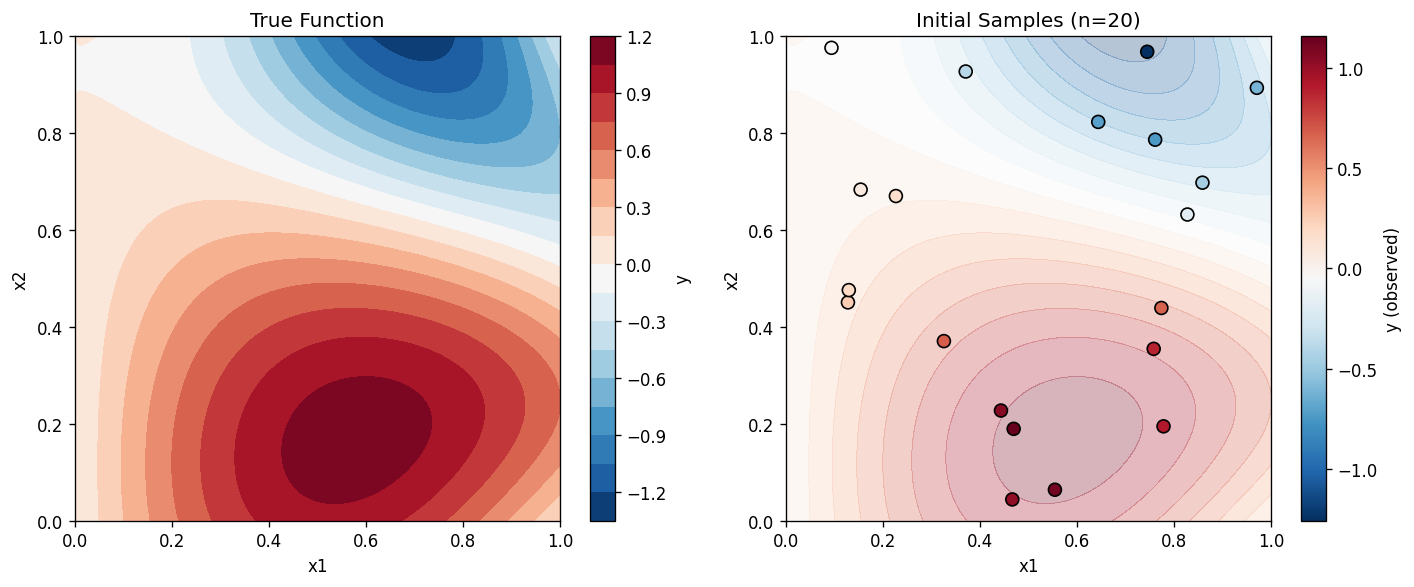

In [3]:
# 真の関数と初期サンプルの可視化
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
c = ax.contourf(X1_grid, X2_grid, Y_grid, levels=20, cmap="RdBu_r")
fig.colorbar(c, ax=ax, label="y")
ax.set_title("True Function")
ax.set_xlabel("x1"); ax.set_ylabel("x2")

ax = axes[1]
ax.contourf(X1_grid, X2_grid, Y_grid, levels=20, cmap="RdBu_r", alpha=0.3)
sc = ax.scatter(initial["X"][:, 0], initial["X"][:, 1],
                c=initial["y"], cmap="RdBu_r", edgecolors="k", s=60, zorder=5)
fig.colorbar(sc, ax=ax, label="y (observed)")
ax.set_title(f"Initial Samples (n={initial['X'].shape[0]})")
ax.set_xlabel("x1"); ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

## 3. サロゲートモデル（ガウス過程回帰）の初期学習

ガウス過程回帰 (GPR) は、各点での**予測値**と**予測の不確実性（標準偏差）**を同時に出力します。
この不確実性こそが、能動学習で「次にどこをサンプリングすべきか」を判断する鍵です。

In [4]:
def build_gpr(X_train, y_train):
    """ガウス過程回帰モデルを構築・学習する"""
    kernel = ConstantKernel(1.0) * RBF(length_scale=0.3) + WhiteKernel(noise_level=0.01)
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=5,
        random_state=42,
    )
    gpr.fit(X_train, y_train)
    return gpr


def evaluate_model(gpr, X_eval, y_eval):
    """グリッド全体でのRMSEを計算"""
    y_pred = gpr.predict(X_eval)
    return np.sqrt(mean_squared_error(y_eval, y_pred))


def plot_gpr_state(gpr, X_train, X1_grid, X2_grid, Y_grid, title_suffix=""):
    """GPRの現在の予測と不確実性を可視化"""
    X_flat = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])
    y_pred, y_std = gpr.predict(X_flat, return_std=True)
    Y_pred = y_pred.reshape(X1_grid.shape)
    Y_std = y_std.reshape(X1_grid.shape)
    Y_err = np.abs(Y_pred - Y_grid)

    fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

    # 予測値
    ax = axes[0]
    c = ax.contourf(X1_grid, X2_grid, Y_pred, levels=20, cmap="RdBu_r")
    ax.scatter(X_train[:, 0], X_train[:, 1], c="k", s=15, zorder=5)
    fig.colorbar(c, ax=ax)
    ax.set_title(f"GPR Prediction (n={len(X_train)})")
    ax.set_xlabel("x1"); ax.set_ylabel("x2")

    # 不確実性
    ax = axes[1]
    c = ax.contourf(X1_grid, X2_grid, Y_std, levels=20, cmap="YlOrRd")
    ax.scatter(X_train[:, 0], X_train[:, 1], c="k", s=15, zorder=5)
    fig.colorbar(c, ax=ax)
    ax.set_title("Prediction Uncertainty (std)")
    ax.set_xlabel("x1"); ax.set_ylabel("x2")

    # 予測誤差
    ax = axes[2]
    c = ax.contourf(X1_grid, X2_grid, Y_err, levels=20, cmap="YlOrRd")
    ax.scatter(X_train[:, 0], X_train[:, 1], c="k", s=15, zorder=5)
    fig.colorbar(c, ax=ax)
    ax.set_title("Absolute Error |pred - true|")
    ax.set_xlabel("x1"); ax.set_ylabel("x2")

    if title_suffix:
        fig.suptitle(title_suffix, fontsize=13, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()

Initial RMSE: 0.1091


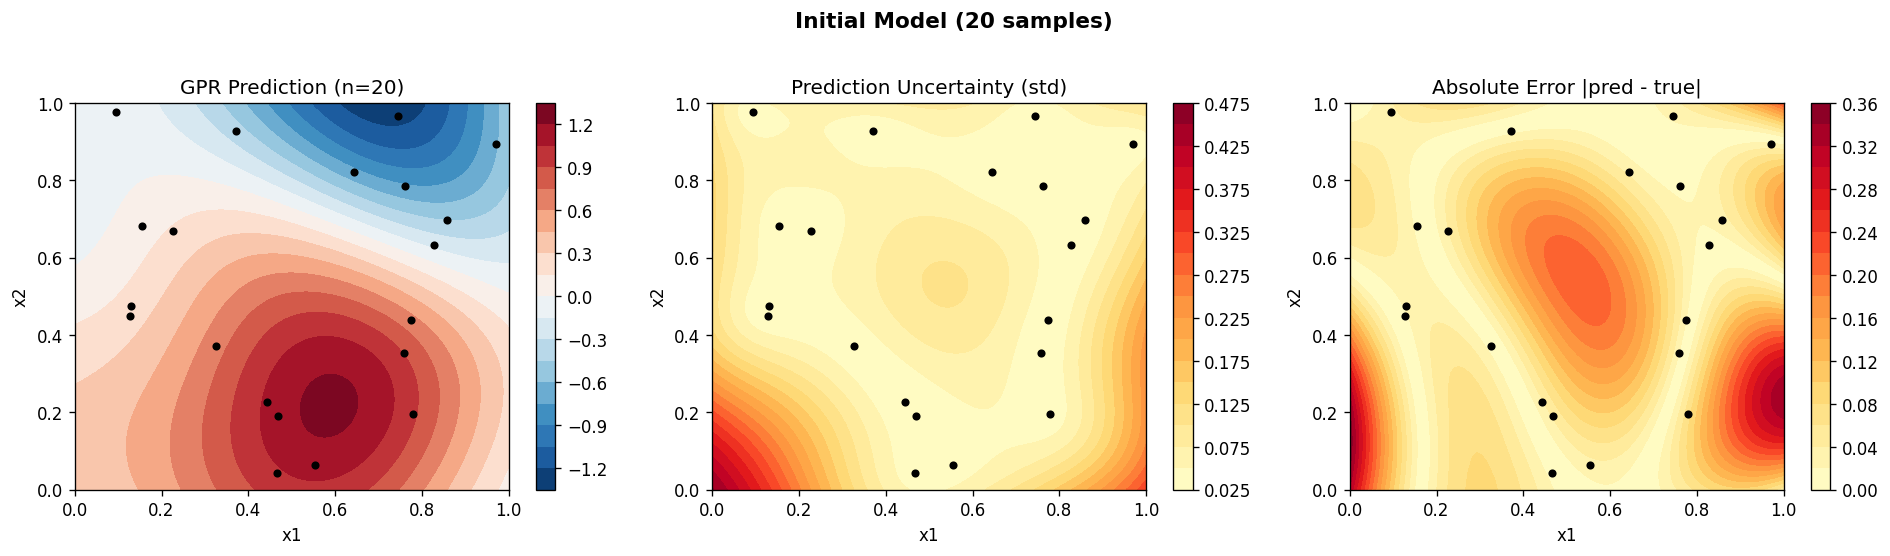

In [5]:
# 初期サンプルのみで学習
gpr_init = build_gpr(initial["X"], initial["y"])
rmse_init = evaluate_model(gpr_init, X_grid_flat, y_grid_flat)
print(f"Initial RMSE: {rmse_init:.4f}")

plot_gpr_state(gpr_init, initial["X"], X1_grid, X2_grid, Y_grid,
               title_suffix="Initial Model (20 samples)")

## 4. 能動学習ループ

### 獲得関数：最大不確実性サンプリング (Uncertainty Sampling)

最もシンプルな能動学習戦略です。候補プールの中から**GPRの予測標準偏差が最大の点**を選びます。

```
次のサンプル = argmax_{x ∈ 候補プール} σ(x)
```

直感的には「モデルが最も自信のない場所」を優先的に学習する、という戦略です。

In [6]:
def active_learning_loop(X_init, y_init, X_pool, y_pool,
                         X_eval, y_eval, n_iterations=30, batch_size=1):
    """
    能動学習ループ（不確実性サンプリング）

    Parameters
    ----------
    X_init, y_init : 初期学習データ
    X_pool, y_pool : 候補プール（y_poolは「実験すれば得られる」真のラベル）
    X_eval, y_eval : 評価用データ（グリッド全体）
    n_iterations   : 能動学習の反復回数
    batch_size     : 1回に追加するサンプル数

    Returns
    -------
    history : dict（RMSE履歴、選択された点など）
    """
    X_train = X_init.copy()
    y_train = y_init.copy()
    X_remaining = X_pool.copy()
    y_remaining = y_pool.copy()

    rmse_history = []
    selected_points = []

    for i in range(n_iterations):
        # 1. GPRを学習
        gpr = build_gpr(X_train, y_train)
        rmse = evaluate_model(gpr, X_eval, y_eval)
        rmse_history.append(rmse)

        # 2. 候補プールでの不確実性を計算
        _, y_std = gpr.predict(X_remaining, return_std=True)

        # 3. 不確実性が最大の点を選択
        idx = np.argsort(y_std)[-batch_size:]

        # 4. 選択した点を学習データに追加
        selected_points.append(X_remaining[idx].copy())
        X_train = np.vstack([X_train, X_remaining[idx]])
        y_train = np.concatenate([y_train, y_remaining[idx]])

        # 5. 候補プールから除去
        X_remaining = np.delete(X_remaining, idx, axis=0)
        y_remaining = np.delete(y_remaining, idx, axis=0)

    # 最終モデルの評価
    gpr_final = build_gpr(X_train, y_train)
    rmse_history.append(evaluate_model(gpr_final, X_eval, y_eval))

    return {
        "rmse_history": rmse_history,
        "selected_points": selected_points,
        "gpr_final": gpr_final,
        "X_train_final": X_train,
        "y_train_final": y_train,
    }

In [7]:
N_ITERATIONS = 30

print(f"能動学習を実行中... ({N_ITERATIONS} iterations)")
al_result = active_learning_loop(
    initial["X"], initial["y"],
    pool["X"], pool["y"],
    X_grid_flat, y_grid_flat,
    n_iterations=N_ITERATIONS,
)
print(f"RMSE: {al_result['rmse_history'][0]:.4f} → {al_result['rmse_history'][-1]:.4f}")
print(f"学習データ: {initial['X'].shape[0]} → {al_result['X_train_final'].shape[0]} 点")

能動学習を実行中... (30 iterations)


RMSE: 0.1091 → 0.0329
学習データ: 20 → 50 点


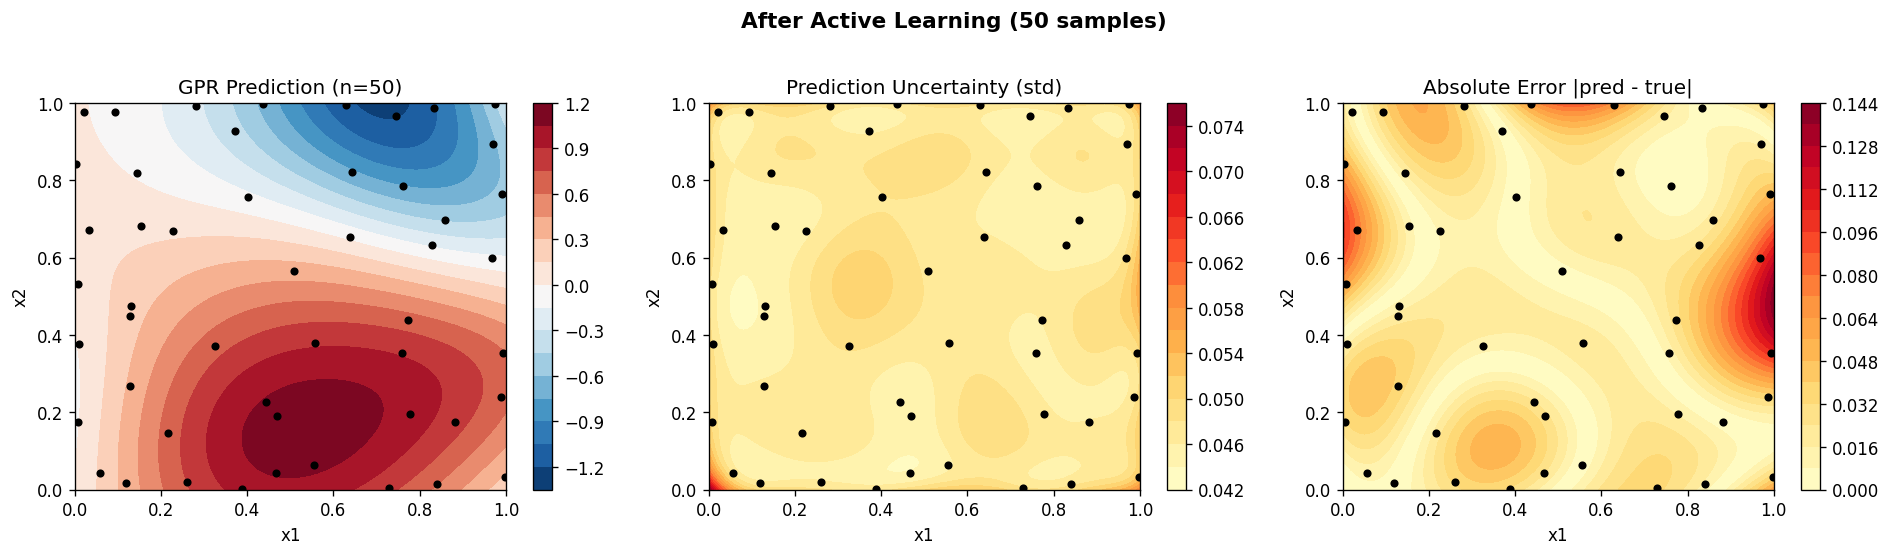

In [8]:
# 能動学習後のモデル状態を可視化
plot_gpr_state(al_result["gpr_final"], al_result["X_train_final"],
               X1_grid, X2_grid, Y_grid,
               title_suffix=f"After Active Learning ({al_result['X_train_final'].shape[0]} samples)")

### 能動学習が選んだ点の可視化

能動学習がどの順番でどの点を選んだかを確認します。初期の段階では空白地帯を、後半では複雑な領域を選ぶ傾向が見えるはずです。

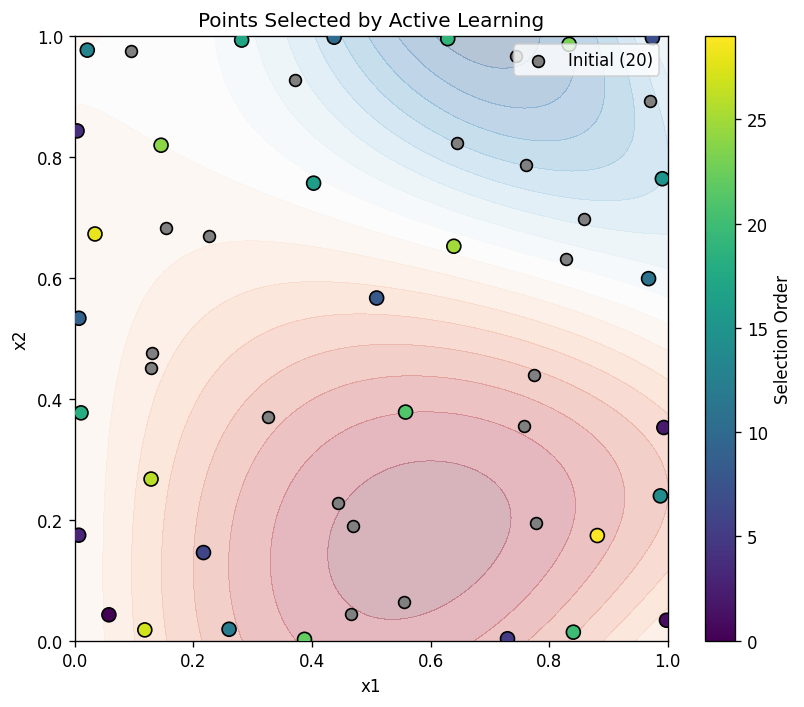

In [9]:
# 能動学習で選択された点の順序を可視化
fig, ax = plt.subplots(figsize=(7, 6))
ax.contourf(X1_grid, X2_grid, Y_grid, levels=20, cmap="RdBu_r", alpha=0.3)

# 初期サンプル
ax.scatter(initial["X"][:, 0], initial["X"][:, 1],
           c="gray", edgecolors="k", s=50, zorder=4, label="Initial (20)")

# 能動学習で選ばれた点（色で順序を表現）
selected = np.vstack(al_result["selected_points"])
order = np.arange(len(selected))
sc = ax.scatter(selected[:, 0], selected[:, 1],
                c=order, cmap="viridis", edgecolors="k", s=70, zorder=5)
cbar = fig.colorbar(sc, ax=ax, label="Selection Order")

ax.set_title("Points Selected by Active Learning")
ax.set_xlabel("x1"); ax.set_ylabel("x2")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

## 5. ランダムサンプリングとの比較

能動学習の効果を示すために、同じ候補プールからランダムに点を選ぶ戦略と比較します。

In [10]:
def random_sampling_loop(X_init, y_init, X_pool, y_pool,
                         X_eval, y_eval, n_iterations=30, batch_size=1, seed=0):
    """ランダムサンプリングによるベースライン"""
    rng = np.random.default_rng(seed)
    X_train = X_init.copy()
    y_train = y_init.copy()
    X_remaining = X_pool.copy()
    y_remaining = y_pool.copy()

    rmse_history = []

    for i in range(n_iterations):
        gpr = build_gpr(X_train, y_train)
        rmse = evaluate_model(gpr, X_eval, y_eval)
        rmse_history.append(rmse)

        # ランダムに選択
        idx = rng.choice(len(X_remaining), size=batch_size, replace=False)
        X_train = np.vstack([X_train, X_remaining[idx]])
        y_train = np.concatenate([y_train, y_remaining[idx]])
        X_remaining = np.delete(X_remaining, idx, axis=0)
        y_remaining = np.delete(y_remaining, idx, axis=0)

    gpr_final = build_gpr(X_train, y_train)
    rmse_history.append(evaluate_model(gpr_final, X_eval, y_eval))

    return {
        "rmse_history": rmse_history,
        "gpr_final": gpr_final,
        "X_train_final": X_train,
    }

print(f"ランダムサンプリングを実行中... ({N_ITERATIONS} iterations)")
rand_result = random_sampling_loop(
    initial["X"], initial["y"],
    pool["X"], pool["y"],
    X_grid_flat, y_grid_flat,
    n_iterations=N_ITERATIONS,
)
print(f"RMSE: {rand_result['rmse_history'][0]:.4f} → {rand_result['rmse_history'][-1]:.4f}")

ランダムサンプリングを実行中... (30 iterations)


RMSE: 0.1091 → 0.0426


## 6. 結果の比較

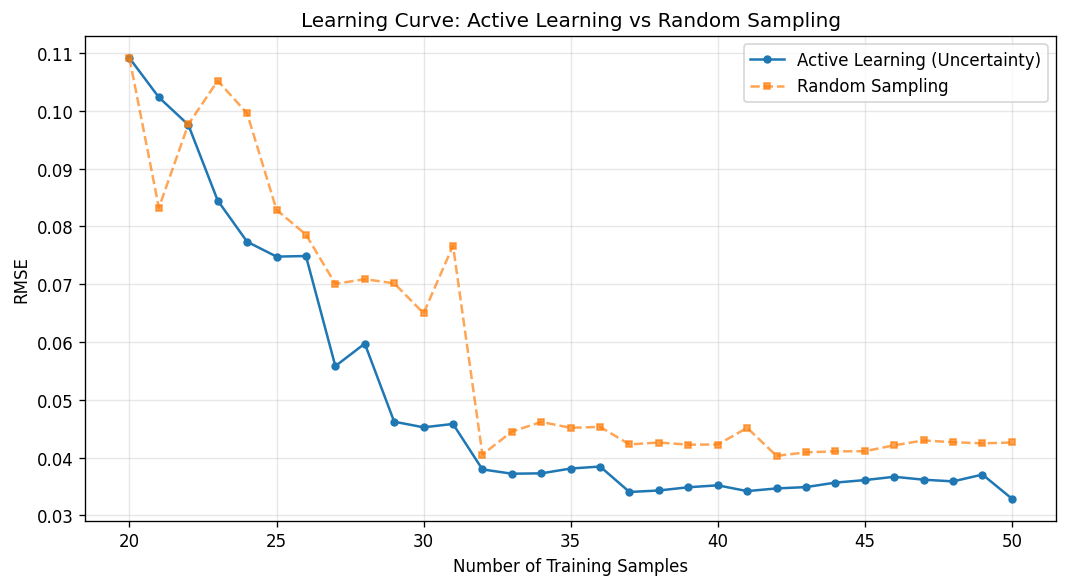


最終RMSE比較 (50 samples)
  Active Learning:  0.0329
  Random Sampling:  0.0426
  Improvement:      +22.8%


In [11]:
# RMSE学習曲線の比較
n_samples = np.arange(initial["X"].shape[0],
                      initial["X"].shape[0] + N_ITERATIONS + 1)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(n_samples, al_result["rmse_history"], "o-", label="Active Learning (Uncertainty)", markersize=4)
ax.plot(n_samples, rand_result["rmse_history"], "s--", label="Random Sampling", markersize=4, alpha=0.7)
ax.set_xlabel("Number of Training Samples")
ax.set_ylabel("RMSE")
ax.set_title("Learning Curve: Active Learning vs Random Sampling")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n{'':=<50}")
print(f"最終RMSE比較 ({n_samples[-1]} samples)")
print(f"{'':=<50}")
print(f"  Active Learning:  {al_result['rmse_history'][-1]:.4f}")
print(f"  Random Sampling:  {rand_result['rmse_history'][-1]:.4f}")
improvement = (1 - al_result['rmse_history'][-1] / rand_result['rmse_history'][-1]) * 100
print(f"  Improvement:      {improvement:+.1f}%")

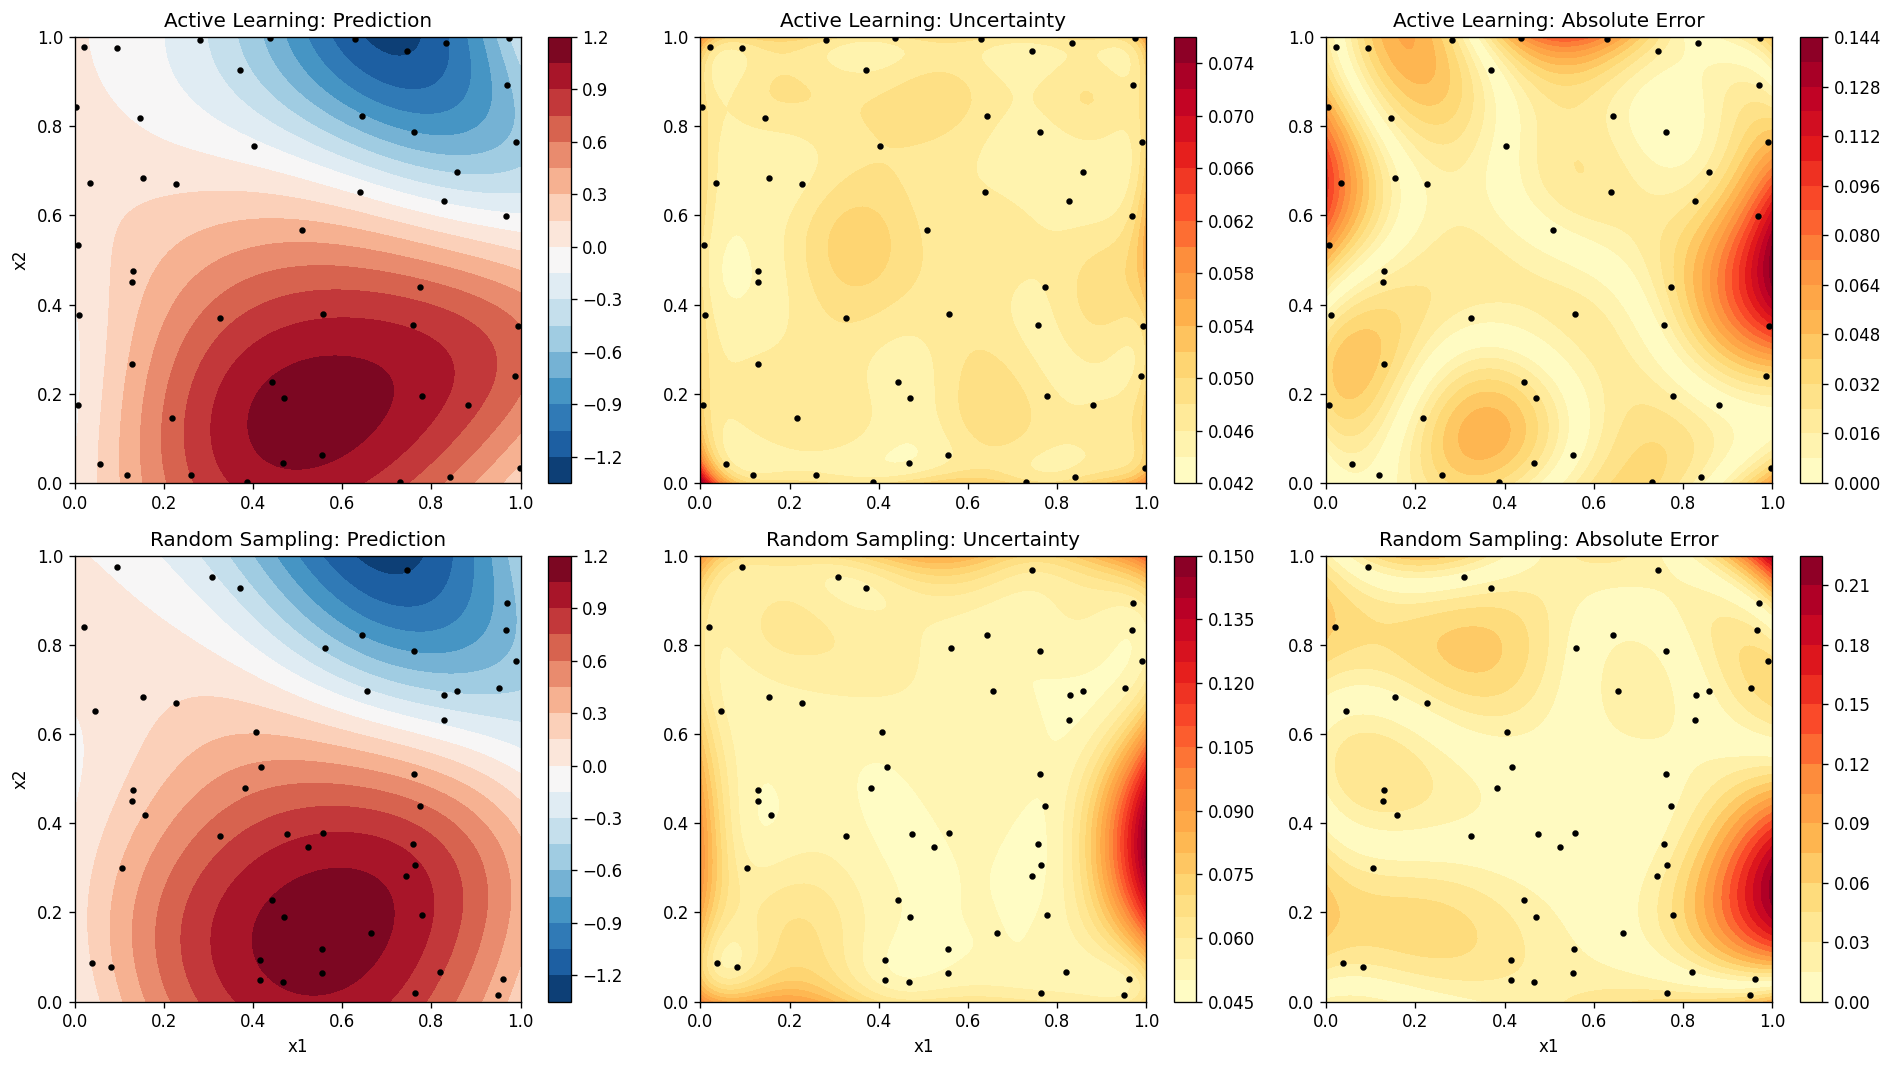

In [12]:
# 最終モデルの比較（能動学習 vs ランダム）
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

for row, (result, label) in enumerate([
    (al_result, "Active Learning"),
    (rand_result, "Random Sampling"),
]):
    gpr = result["gpr_final"]
    X_train = result["X_train_final"]
    X_flat = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])
    y_pred, y_std = gpr.predict(X_flat, return_std=True)

    Y_pred = y_pred.reshape(X1_grid.shape)
    Y_std = y_std.reshape(X1_grid.shape)
    Y_err = np.abs(Y_pred - Y_grid)

    ax = axes[row, 0]
    c = ax.contourf(X1_grid, X2_grid, Y_pred, levels=20, cmap="RdBu_r")
    ax.scatter(X_train[:, 0], X_train[:, 1], c="k", s=8, zorder=5)
    fig.colorbar(c, ax=ax)
    ax.set_title(f"{label}: Prediction")
    ax.set_ylabel("x2")

    ax = axes[row, 1]
    c = ax.contourf(X1_grid, X2_grid, Y_std, levels=20, cmap="YlOrRd")
    ax.scatter(X_train[:, 0], X_train[:, 1], c="k", s=8, zorder=5)
    fig.colorbar(c, ax=ax)
    ax.set_title(f"{label}: Uncertainty")

    ax = axes[row, 2]
    c = ax.contourf(X1_grid, X2_grid, Y_err, levels=20, cmap="YlOrRd")
    ax.scatter(X_train[:, 0], X_train[:, 1], c="k", s=8, zorder=5)
    fig.colorbar(c, ax=ax)
    ax.set_title(f"{label}: Absolute Error")

for ax in axes[1]:
    ax.set_xlabel("x1")
axes[0, 0].set_ylabel("x2"); axes[1, 0].set_ylabel("x2")

plt.tight_layout()
plt.show()

## 7. まとめ

### 観察されたこと

1. **学習曲線**: 能動学習はランダムサンプリングよりも少ないデータで低いRMSEを達成
2. **サンプル選択**: 能動学習は初期段階ではデータの空白地帯を、後半では関数の変動が大きい領域を重点的にサンプリング
3. **不確実性**: 能動学習後は全体的に不確実性が均一に低下。ランダムでは偏りが残る

### 能動学習の利点

- シミュレーション回数（＝コスト）を削減しつつ、サロゲートモデルの精度を確保
- 「どこを実験すべきか」の意思決定を自動化

### 発展的な話題

- **Bayesian Optimization**: 不確実性の低減ではなく、目的関数の最適値探索に特化した能動学習
- **バッチ能動学習**: 一度に複数点を選択（並列実験に対応）
- **多目的能動学習**: 複数の性能指標を同時に考慮